In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random

# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load Data

In [2]:
filename = 'Datasets/All_subjects_RDmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train1 = np.array(data["train_img"])
y_train1 = np.array(data["train_labels"])
x_test1 = np.array(data["test_img"])
y_test1 = np.array(data["test_labels"])
data.close()
print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)

Selected File: Datasets/All_subjects_RDmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [3]:
filename = 'Datasets/All_subjects_RAmap.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train2 = np.array(data["train_img"])
y_train2 = np.array(data["train_labels"])
x_test2 = np.array(data["test_img"])
y_test2 = np.array(data["test_labels"])
data.close()
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

Selected File: Datasets/All_subjects_RAmap.hdf5
(527, 605, 128, 128, 3)
(527, 605, 19)
(132, 605, 128, 128, 3)
(132, 605, 19)


In [4]:
# windowed RD
interval = range(0,600)
x_train11 = np.reshape(x_train1[:,interval,:,:,:], (x_train1.shape[0],120,5,x_train1.shape[2],x_train1.shape[3],x_train1.shape[4]))
x_test11 = np.reshape(x_test1[:,interval,:,:,:], (x_test1.shape[0],120,5,x_test1.shape[2],x_test1.shape[3],x_test1.shape[4]))
y_train11 = np.reshape(np.argmax(y_train1[:,interval,:],-1), (y_train1.shape[0],120,5))
y_test11 = np.reshape(np.argmax(y_test1[:,interval,:],-1), (y_test1.shape[0],120,5))
y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)  

# windowed RA
x_train12 = np.reshape(x_train2[:,interval,:,:,:], (x_train2.shape[0],120,5,x_train2.shape[2],x_train2.shape[3],x_train2.shape[4]))
x_test12 = np.reshape(x_test2[:,interval,:,:,:], (x_test2.shape[0],120,5,x_test2.shape[2],x_test2.shape[3],x_test2.shape[4]))
y_train12 = np.reshape(np.argmax(y_train2[:,interval,:],-1), (y_train2.shape[0],120,5))
y_test12 = np.reshape(np.argmax(y_test2[:,interval,:],-1), (y_test2.shape[0],120,5))
y_train12 = to_categorical(np.squeeze(stats.mode(y_train12,2)[0]))
y_test12 = to_categorical(np.squeeze(stats.mode(y_test12,2)[0]))
print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape) 

(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)
(527, 120, 5, 128, 128, 3)
(527, 120, 19)
(132, 120, 5, 128, 128, 3)
(132, 120, 19)


In [5]:
filename = 'Datasets/All_subjects_spectrogram.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
x_train3 = np.array(data["train_img"])
y_train3 = np.array(data["train_labels"])
x_test3 = np.array(data["test_img"])
y_test3 = np.array(data["test_labels"])
data.close()
print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)

Selected File: Datasets/All_subjects_spectrogram.hdf5
(527, 120, 128, 128, 3)
(527, 120, 19)
(132, 120, 128, 128, 3)
(132, 120, 19)


In [6]:
filename = 'Datasets/All_subjects_margins_and_ctc_label.hdf5'
data = h5py.File(filename, "r")
print('Selected File: '+str(filename))
margin_tr = np.array(data["train_img"])
ctc_tr = np.squeeze(np.array(data["train_labels"])).astype('U12')
margin_ts = np.array(data["test_img"])
ctc_ts = np.squeeze(np.array(data["test_labels"])).astype('U12')
data.close()
print(margin_tr.shape)
print(ctc_tr.shape)
print(margin_ts.shape)
print(ctc_ts.shape)

Selected File: Datasets/All_subjects_margins_and_ctc_label.hdf5
(527, 1482)
(527,)
(132, 1482)
(132,)


In [7]:
np.unique(ctc_tr)

array(['ABSDTSETSFTC', 'ABSGTSHTSITC', 'ABSJTSKTSLTC', 'ABSMTSNTSOTC',
       'ABSPTSQTSRTC'], dtype='<U12')

In [8]:
# check windowed labels
idx = 212
print(np.argmax(y_train11[idx],-1))
print(np.argmax(y_train3[idx],-1))

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2
 2 2 2 2 2 2 2 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 5 5 5 5 5 5 5
 5 5 5 5 5 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 3 3 3
 3 3 3 3 3 3 3 0 0]
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2
 2 2 2 2 2 2 2 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 5 5 5 5 5 5 5
 5 5 5 5 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 3 3 3 3
 3 3 3 3 3 3 0 0 0]


In [9]:
# Range-weighted Energy
def RWE(video): # video is a np array
    rwe_vec = []
    frames = video.shape[0]
    height = video.shape[2]
    width = video.shape[1]
    
    x = np.zeros(shape=video.shape)
    for rangeBin in range(0,height):
        x[:,rangeBin,:,:] = 1/(rangeBin+np.finfo(float).eps)**2 * video[:,rangeBin,:,:] 
    rwe_vec = np.sum(x,axis=(1,2,3))   
    return rwe_vec

In [10]:
# generate RWE plots
rwes_test = []
rwes_train = []
for i in range(0,len(x_test1)):
    vec = RWE(x_test1[i,:,:,:,:]) # train for figs
    rwes_test.append(vec)
for i in range(0,len(x_train1)):
    vec = RWE(x_train1[i,:,:,:,:]) # train for figs
    rwes_train.append(vec)

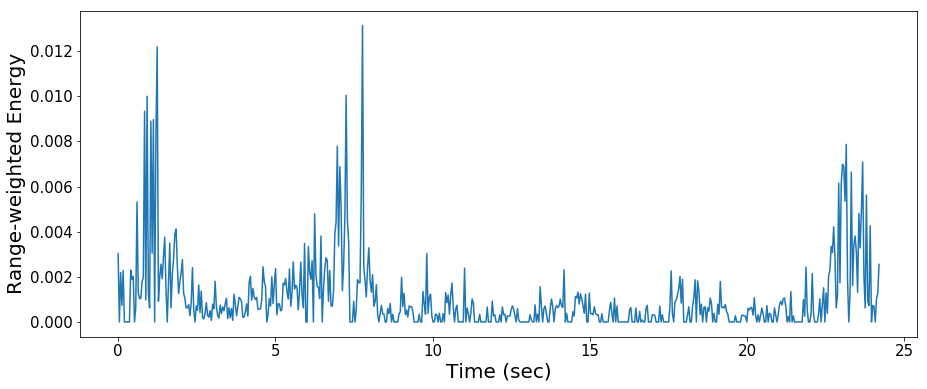

In [11]:
# No annotation sample
idx = 27
fps = 25
timevec = np.linspace(0,24.2,y_train1.shape[1])
matplotlib.rc('xtick',labelsize=15)
matplotlib.rc('ytick',labelsize=15)
p1,=plt.plot(timevec, rwes_test[idx])
plt.xlabel('Time (sec)',fontsize=20, weight='normal')
plt.ylabel('Range-weighted Energy',fontsize=20, weight='normal')
fig = plt.gcf()
fig.set_size_inches(15,6)
# plt.savefig('seq1 no annot.png')

##### STA LTA

In [12]:
# old one
def sta_lta(vec,nsta,nlta,thresh,win):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    for i in range(0,len(vec)-nsta-nlta+1):
        if sum(vec[i+nlta:i+nlta+nsta])==0:
            continue
        if thresh < sum(vec[i:i+nlta]) / sum(vec[i+nlta:i+nlta+nsta]):
            if i+nlta-win < 0:
                continue
            if win > nlta:
                vec2[i+nlta-win:i] = vec[i+nlta-win:i]
                mask[i+nlta-win:i] = 1
            if win < nlta:
                vec2[i-nlta+win:i] = vec[i-nlta+win:i]
                mask[i-nlta+win:i] = 1
            i += nlta
    return vec2, mask

In [14]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

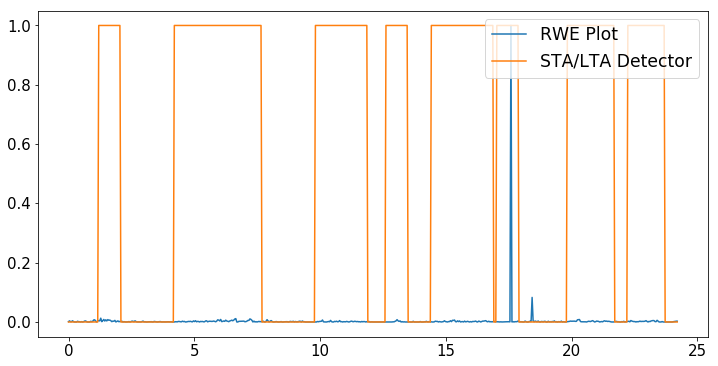

In [16]:
nsta = 15
nlta = 2*nsta
win = 50
thresh = 2
idx = 1
stepsz = 5 # 0.2 sec
init_th = 0.6
stop_th = 0.3
vecs = np.zeros(np.argmax(y_test1,-1).shape)
timevec = np.linspace(0,24.2,len(rwes_test[0]))
mask = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(rwes_test)):
    vecs[i], mask[i] = sta_lta2(rwes_test[i],nlta,nsta,init_th,stop_th,stepsz)
mask_win = mask[:,::5]
mask_win.shape
plt.plot(timevec,rwes_test[idx]/max(rwes_test[idx]))
plt.plot(timevec,mask[idx])
plt.legend(['RWE Plot','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.savefig('seq1 no annot.png')

In [10]:
# nsta = 15
# nlta = 2*nsta
# stepsz = 10
# idx = 27
# init_th = 0.55
# stop_th = 0.3
# vecs_train = np.zeros(np.argmax(y_train1,-1).shape)
# mask_train = np.zeros(np.argmax(y_train1,-1).shape)
# vecs_test = np.zeros(np.argmax(y_train1,-1).shape)
# mask_test = np.zeros(np.argmax(y_test1,-1).shape)
# for i in range(len(rwes_train)):
#     vecs_train[i], mask_train[i] = sta_lta2(rwes_train[i],nlta,nsta,init_th,stop_th,stepsz)
# mask_train_win = mask_train[:,::5]
# for i in range(len(rwes_test)):
#     vecs_test[i], mask_test[i] = sta_lta2(rwes_test[i],nlta,nsta,init_th,stop_th,stepsz)
# mask_test_win = mask_test[:,::5]
# plt.plot(timevec[::5],mask_test_win[idx])
# # plt.figure()
# normalized = vecs_test[idx][::5]/max(vecs_test[idx][::5])
# plt.plot(timevec[::5],normalized)
# plt.figure()
# plt.plot(timevec[::5],rwes_test[idx][::5])

## Margins

In [11]:
# # No annotation sample
# idx = 27
# fps = 25
# timevec = np.linspace(0,24.2,margin_ts.shape[1])
# matplotlib.rc('xtick',labelsize=15)
# matplotlib.rc('ytick',labelsize=15)
# p1,=plt.plot(timevec, margin_ts[idx])
# plt.xlabel('Time (sec)',fontsize=20, weight='normal')
# plt.ylabel('Euclidean Distance of Upper & Lower Envelope',fontsize=15, weight='normal')
# fig = plt.gcf()
# fig.set_size_inches(15,6)
# # plt.savefig('seq1 no annot.png')
# # im = np.concatenate(x_test3[idx]*255,0)
# # img = Image.fromarray(im, 'RGB')
# # img.show()

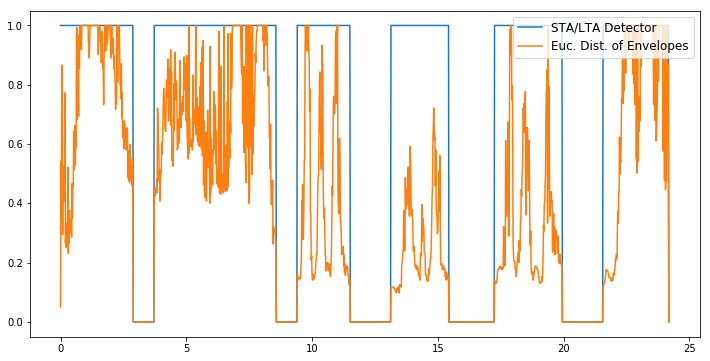

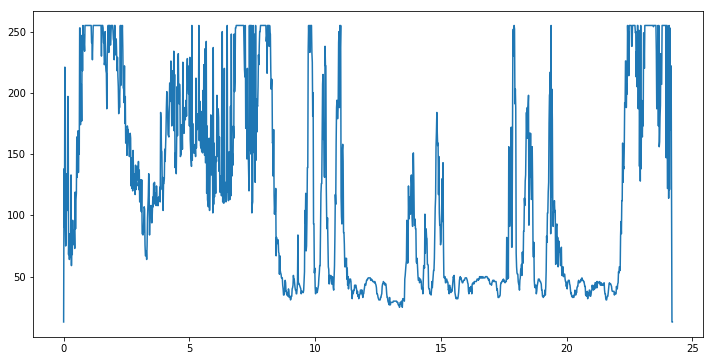

In [12]:
duration = 24.2
nsta_sec = 0.7
ratio = margin_tr.shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,margin_ts.shape[1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(margin_tr)):
    vecs_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(margin_tr[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(margin_ts)):
    vecs_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(margin_ts[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)
p1, = plt.plot(timevec,mask_test[idx])
# plt.figure()
normalized = vecs_test[idx]/max(vecs_test[idx])
p2, = plt.plot(timevec,normalized)
plt.legend(['STA/LTA Detector','Euc. Dist. of Envelopes'], loc = 'upper right', fontsize = 'large')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.figure()
plt.plot(timevec,margin_ts[idx])
fig = plt.gcf()
fig.set_size_inches(12,6)

In [13]:
# label check
idx = 192
print(np.unique(np.argmax(y_train1[idx],-1)))
print(np.unique(np.argmax(y_train3[idx],-1)))
# print(str(ord(ctc_tr[idx][3]))+'-'+str(ord(ctc_tr[idx][6]))+'-'+str(ord(ctc_tr[idx][9])))
print(ctc_tr[idx])

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
ABSDTSETSFTC


In [14]:
mask_train.shape[-1]

1482

In [15]:
# downsample the mask to vid
mask_vid_tr = np.zeros(np.argmax(y_train1,-1).shape)
ratio1 = mask_train.shape[-1]/mask_vid_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_vid_tr[i,int(j/ratio1)] = 1
mask_vid_ts = np.zeros(np.argmax(y_test1,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_vid_ts[i,int(j/ratio1)] = 1

# downsample the mask to spect
mask_spect_tr = np.zeros(np.argmax(y_train3,-1).shape)
ratio2 = mask_train.shape[-1]/mask_spect_tr.shape[-1]
for i in range(len(mask_train)):
    for j in range(mask_train.shape[-1]):
        if mask_train[i,j] == 0:
            continue
        else:
            mask_spect_tr[i,int(j/ratio2)] = 1
mask_spect_ts = np.zeros(np.argmax(y_test3,-1).shape)
for i in range(len(mask_test)):
    for j in range(mask_test.shape[-1]):
        if mask_test[i,j] == 0:
            continue
        else:
            mask_spect_ts[i,int(j/ratio2)] = 1
print('Mask shapes:')
print(mask_vid_tr.shape)
print(mask_vid_ts.shape)
print(mask_spect_tr.shape)
print(mask_spect_ts.shape)

Mask shapes:
(527, 605)
(132, 605)
(527, 120)
(132, 120)


# Single label classification

In [27]:
# Mask videos
x1train = []
y1train = []
flag = 0
for i in range(len(mask_vid_tr)):
    for j in range(mask_vid_tr.shape[1]):
        if mask_vid_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                x1train.append(x_train2[i,startpt:stoppt])
                y1train.append(np.squeeze(stats.mode(np.argmax(y_train1[i,startpt:stoppt],-1))[0]))
                flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1train = np.asarray(x1train)
y1train = to_categorical(np.array(y1train))
x1test = []
y1test = []
flag = 0
for i in range(len(mask_vid_ts)):
    for j in range(mask_vid_ts.shape[1]):
        if mask_vid_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                x1test.append(x_test2[i,startpt:stoppt])
                y1test.append(np.squeeze(stats.mode(np.argmax(y_test1[i,startpt:stoppt],-1))[0]))
                flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1test = np.asarray(x1test)
y1test = to_categorical(np.array(y1test))
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)

(3411,)
(3411, 19)
(831,)
(831, 19)


In [28]:
# Mask spectrograms
x3train = []
y3train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt>startpt:
                    x3train.append(x_train3[i,startpt:stoppt])
                    y3train.append(np.squeeze(stats.mode(np.argmax(y_train3[i,startpt:stoppt],-1))[0]))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3train = np.asarray(x3train)
y3train = to_categorical(np.array(y3train))
x3test = []
y3test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt>startpt:
                    x3test.append(x_test3[i,startpt:stoppt])
                    y3test.append(np.squeeze(stats.mode(np.argmax(y_test3[i,startpt:stoppt],-1))[0]))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3test = np.asarray(x3test)
y3test = to_categorical(np.array(y3test))
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(1177,)
(1177, 19)
(280,)
(280, 19)


In [29]:
yx = np.argmax(y3train,-1)
np.unique(yx)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [30]:
from collections import Counter
print('# of samples in each class:')
counter = Counter(np.argmax(y3train, -1))
counter

# of samples in each class:


Counter({1: 331,
         16: 36,
         18: 35,
         3: 178,
         13: 31,
         14: 31,
         15: 36,
         10: 40,
         11: 39,
         12: 40,
         7: 39,
         8: 42,
         9: 42,
         0: 44,
         2: 87,
         17: 32,
         4: 36,
         5: 29,
         6: 29})

In [31]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

# Detector + Single Vid RD/RA map & mD Classification

In [32]:
epochs, batch_size, verbose, num_class = 10, 1, 1, y1test.shape[-1]
print('Num class: ',str(num_class))
input_shape1 = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3])
input_shape3 = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of RD maps: ',input_shape1)
print('Input shape of spectrograms: ',input_shape3)

Num class:  19
Input shape of RD maps:  (None, 128, 128, 3)
Input shape of spectrograms:  (None, 128, 128, 3)


In [41]:
train_generator = data_generator(x1train, y1train)
test_generator = data_generator(x1test, y1test)

### TD2D CNN + BiLSTM

In [18]:
def tdcnn2d_bilstm():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shape1)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=False))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'],sample_weight_mode="temporal")
        return model 

## 3D CNN + LSTM

In [69]:
def cnn3d_lstm():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer = Input(shape = input_shape1)
        x = Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu')(inputlayer)
        x = MaxPooling3D(pool_size=(1,2,2))(x)
        x = Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
        x = MaxPooling3D(pool_size=(1,2,2))(x)
        x = Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
        x = MaxPooling3D(pool_size=(1,2,2))(x)
    #     x = Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
    #     x = MaxPooling3D(pool_size=(1,2,2))(x)
    #     x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer)
    #     x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
    #     x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
    #     x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
    #     x = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))(x)
    #     x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        out = TimeDistributed(Dense(num_class,activation='softmax'))(x)
        model = keras.Model(inputs=inputlayer, outputs=[out]) # keras.Model
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model

In [125]:
model11 = tdcnn2d_bilstm()
model11.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, 128, 128, 3 0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, None, 128, 128, 8) 224       
_________________________________________________________________
time_distributed_50 (TimeDis (None, None, 64, 64, 8)   0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, None, 64, 64, 16)  1168      
_________________________________________________________________
time_distributed_52 (TimeDis (None, None, 32, 32, 16)  0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, None, 32, 32, 32)  4640      
_________________________________________________________________
time_distributed_54 (TimeDis (None, None, 16, 16, 32)

### Train

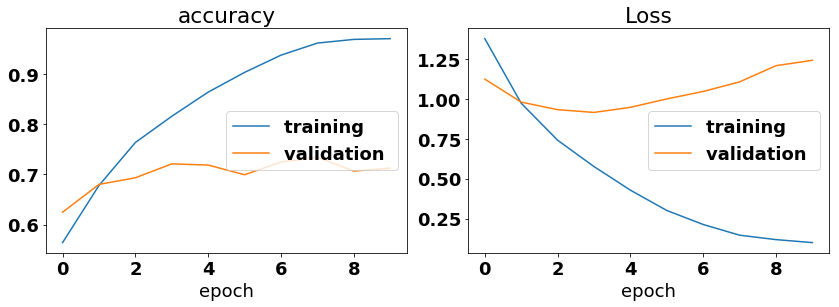

accuracy
	training         	 (min:    0.564, max:    0.998, cur:    0.970)
	validation       	 (min:    0.625, max:    0.952, cur:    0.712)
Loss
	training         	 (min:    0.007, max:    1.465, cur:    0.100)
	validation       	 (min:    0.146, max:    1.355, cur:    1.242)
3411/3411 [==============================] - 60s 18ms/step - loss: 0.0999 - accuracy: 0.9701 - val_loss: 1.2423 - val_accuracy: 0.7124


In [126]:
history = model11.fit(train_generator, validation_data=test_generator,
                        epochs=10, batch_size=1, steps_per_epoch = len(x1train), validation_steps = len(x1test), 
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=verbose)

<function matplotlib.pyplot.show(*args, **kw)>

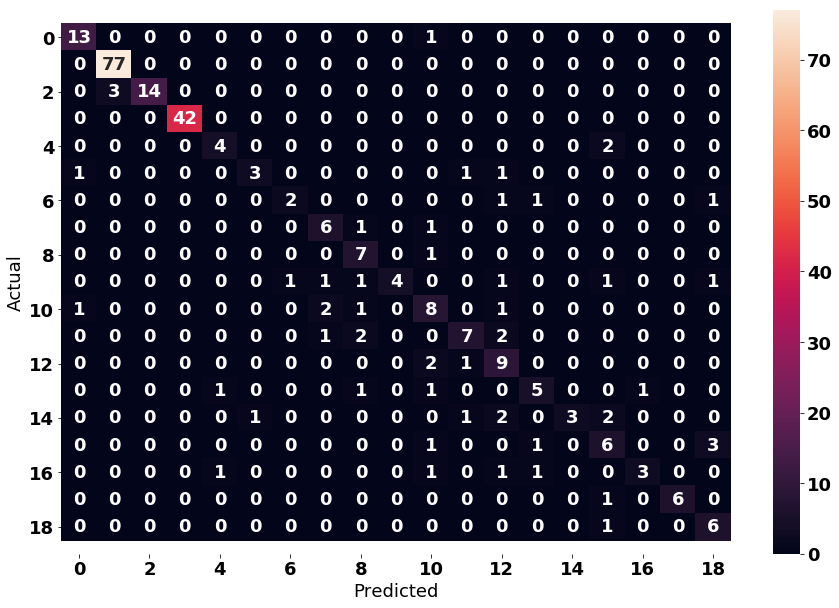

In [91]:
import pandas as pd
import seaborn as sn
# %matplotlib qt 
# opens figure in a new window
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 
# predictions = model.predict(x_test,batch_size=1)
pred = np.zeros(y3test.shape)
for i in range(0,x3test.shape[0]):
    pred[i] = model11.predict(np.expand_dims(x3test[i], axis=0))
Y_pred = np.argmax(pred, axis=-1)
Y_test_int = np.argmax(y3test, axis=-1)
#print(predictions[0:5])
#print(Y_pred[0:5])
#print(Y_test_int[0:5])
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)
fig3 = plt.figure()
sn.heatmap(confusion_matrix, annot=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
fig3.set_size_inches(15,10)
plt.show

In [92]:
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

80.35714285714286

In [127]:
# save model
MODEL_FILE = "Models/td2d-bilstm 19 class single vid RD.json" # save path
WEIGHT_FILE ="Models/td2d-bilstm 19 class single vid RD.h5" # save path

model_json = model11.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model11.save_weights(WEIGHT_FILE)

# Detector + Frame-by-frame Vid RD/RA map & mD Classification

In [102]:
# Mask videos
x1train = []
y1train = []
flag = 0
for i in range(len(mask_vid_tr)):
    for j in range(mask_vid_tr.shape[1]):
        if mask_vid_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt>startpt:
                    x1train.append(x_train2[i,startpt:stoppt])
                    y1train.append(np.argmax(y_train1[i,startpt:stoppt],-1))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1train = np.asarray(x1train)
y1train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1train)])
x1test = []
y1test = []
flag = 0
for i in range(len(mask_vid_ts)):
    for j in range(mask_vid_ts.shape[1]):
        if mask_vid_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt>startpt:
                    x1test.append(x_test2[i,startpt:stoppt])
                    y1test.append(np.squeeze(np.argmax(y_test1[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1test = np.asarray(x1test)
y1test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1test)])
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)

(3411,)
(3411,)
(831,)
(831,)


In [87]:

print(y1test[7].shape)

(77, 19)


In [88]:
# Mask spects
x3train = []
y3train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x3train.append(x_train3[i,startpt:stoppt])
                    y3train.append(np.argmax(y_train3[i,startpt:stoppt],-1))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3train = np.asarray(x3train)
y3train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y3train)])
x3test = []
y3test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x3test.append(x_test3[i,startpt:stoppt])
                    y3test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x3test = np.asarray(x3test)
y3test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y3test)])
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(1154,)
(1154,)
(272,)
(272,)


In [89]:
input_shape11 = (None,x1train[0].shape[1],x1train[0].shape[2],x1train[0].shape[3])
print('Input shape of f-b-f RD maps: ',input_shape11)

Input shape of f-b-f RD maps:  (None, 128, 128, 3)


In [44]:
def tdcnn2d_bilstm_seq():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shape11)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'],sample_weight_mode="temporal")
        return model 

In [97]:
model11 = tdcnn2d_bilstm_seq()
model11.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, 128, 128, 3 0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, None, 128, 128, 8) 224       
_________________________________________________________________
time_distributed_43 (TimeDis (None, None, 64, 64, 8)   0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, None, 64, 64, 16)  1168      
_________________________________________________________________
time_distributed_45 (TimeDis (None, None, 32, 32, 16)  0         
_________________________________________________________________
time_distributed_46 (TimeDis (None, None, 32, 32, 32)  4640      
_________________________________________________________________
time_distributed_47 (TimeDis (None, None, 16, 16, 32)

In [98]:
train_generator = data_generator(x1train, y1train)
test_generator = data_generator(x1test, y1test)

### Train

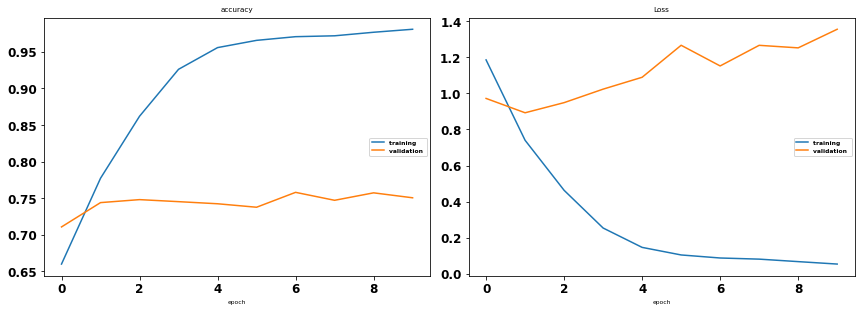

accuracy
	training         	 (min:    0.592, max:    0.998, cur:    0.981)
	validation       	 (min:    0.647, max:    0.952, cur:    0.750)
Loss
	training         	 (min:    0.007, max:    1.465, cur:    0.054)
	validation       	 (min:    0.146, max:    1.355, cur:    1.355)
3411/3411 [==============================] - 63s 18ms/step - loss: 0.0538 - accuracy: 0.9808 - val_loss: 1.3554 - val_accuracy: 0.7504


In [99]:
history = model11.fit(train_generator, validation_data=test_generator,
                        epochs=10, batch_size=1, steps_per_epoch = len(x1train), validation_steps = len(x1test), 
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=verbose)

<function matplotlib.pyplot.show(*args, **kw)>

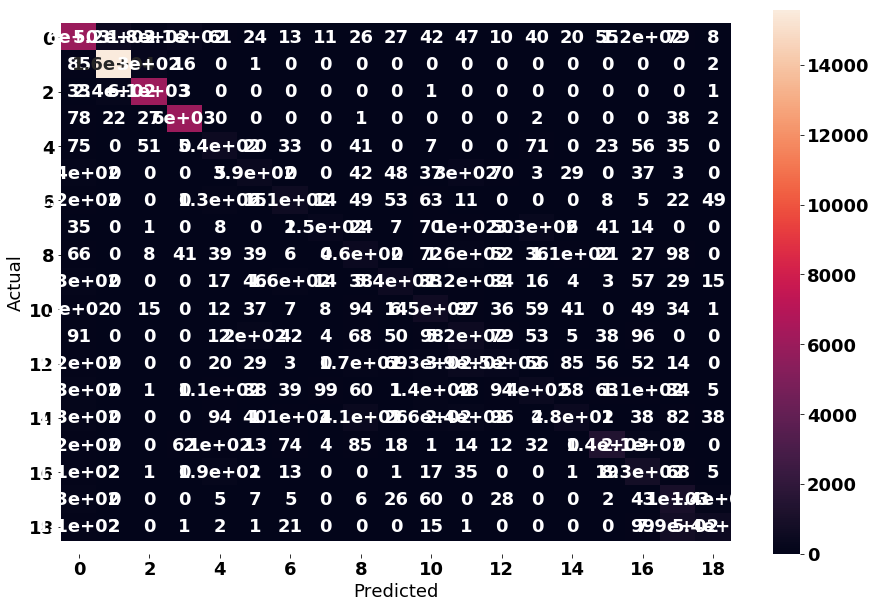

In [112]:
import pandas as pd
import seaborn as sn
# %matplotlib qt 
# opens figure in a new window
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18) 
# predictions = model.predict(x_test,batch_size=1)
pred = [] # np.zeros(y1test.shape)
for i in range(0,x1test.shape[0]):
    pred.append(model11.predict(np.expand_dims(x1test[i], axis=0)))
Y_pred = np.concatenate(np.array([np.argmax(np.squeeze(p), axis=-1) for p in pred]))
Y_test_int = np.concatenate(np.array([np.argmax(np.squeeze(y), axis=-1) for y in y1test]))
#print(predictions[0:5])
#print(Y_pred[0:5])
#print(Y_test_int[0:5])
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)
fig3 = plt.figure()
sn.heatmap(confusion_matrix, annot=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
fig3.set_size_inches(15,10)
plt.show

In [113]:
# yx = np.concatenate(np.array([np.argmax(np.squeeze(y), axis=-1) for y in y3test]),0)
# for i in range(0,10):
#     print(y3test[i].shape)
#     print(y1test[i].shape)

In [114]:
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

75.0397568646853

In [115]:
# save model
MODEL_FILE = "Models/td2d-bilstm 19 class GD fbf seq RA.json" # GD: gesture detector, fbf: frame-by-frame
WEIGHT_FILE ="Models/td2d-bilstm 19 class GD fbf seq RA.h5" # save path

model_json = model11.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model11.save_weights(WEIGHT_FILE)

# Import single model & test

In [147]:
model_addr = 'Models/td2d-bilstm 19 class single vid RA map.json'
weight_addr = 'Models/td2d-bilstm 19 class single vid RA map.h5'
json_file = open(model_addr, 'r')
loaded_model_json = json_file.read()
json_file.close()
modelx = model_from_json(loaded_model_json)
modelx.load_weights(weight_addr)

In [148]:
pred = np.zeros(y1test.shape)
for i in range(0,x1test.shape[0]):
    pred[i] = modelx.predict(np.expand_dims(x1test[i], axis=0))
Y_pred = np.argmax(pred, axis=-1)
Y_test_int = np.argmax(y1test, axis=-1)

In [149]:
cmp = Y_pred == Y_test_int
trues = np.sum(cmp)
acc = trues/len(cmp)*100
acc

64.25992779783394

## No Detector

In [52]:
model11 = tdcnn2d_bilstm_seq()
model11.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 128, 128, 3 0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 128, 128, 8) 224       
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 64, 64, 8)   0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 64, 64, 16)  1168      
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 32, 32, 16)  0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 32, 32, 32)  4640      
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 16, 16, 32) 

In [53]:
train_generator = data_generator(x_train3, y_train3)
test_generator = data_generator(x_test3, y_test3)

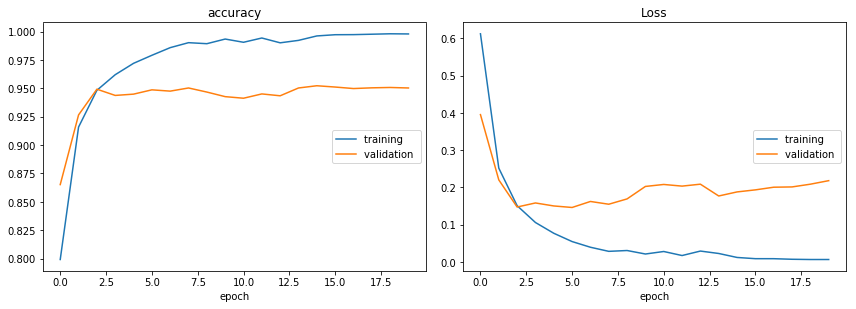

accuracy
	training         	 (min:    0.727, max:    0.998, cur:    0.998)
	validation       	 (min:    0.797, max:    0.952, cur:    0.950)
Loss
	training         	 (min:    0.007, max:    0.880, cur:    0.007)
	validation       	 (min:    0.146, max:    0.595, cur:    0.218)
527/527 [==============================] - 14s 26ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.2183 - val_accuracy: 0.9503


In [54]:
history = model11.fit(train_generator, validation_data=test_generator,
                        epochs=20, batch_size=1, steps_per_epoch = len(x_train3), validation_steps = len(x_test3), 
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=verbose)

In [55]:
# save model
MODEL_FILE = "Models/td2d-bilstm 19 class NO GD fbf seq mD.json" # GD: gesture detector, fbf: frame-by-frame
WEIGHT_FILE ="Models/td2d-bilstm 19 class NO GD fbf seq mD.h5" # save path

model_json = model11.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model11.save_weights(WEIGHT_FILE)

/home/m/.local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<function matplotlib.pyplot.show(*args, **kw)>

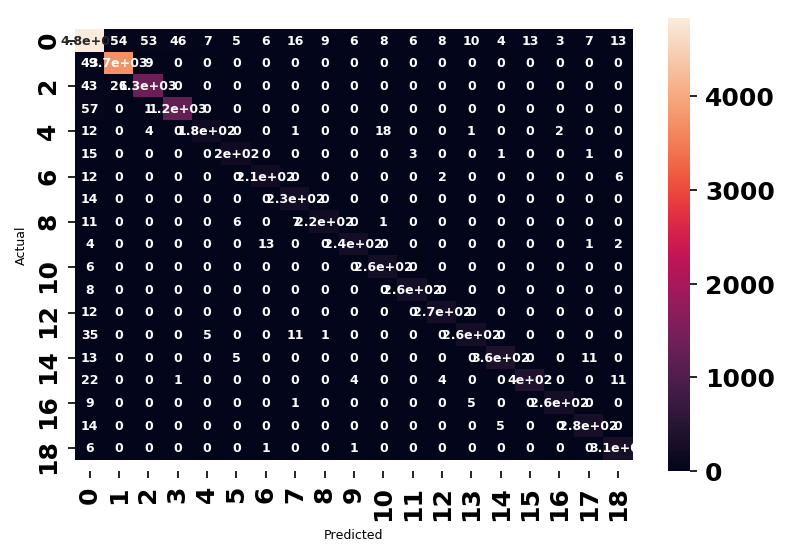

In [57]:
import pandas as pd
import seaborn as sn
# %matplotlib ioff
# opens figure in a new window
font = {'family' : 'normal', 
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font) 
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12) 
# predictions = model11.predict([x_test1,mask_test],batch_size=batch_size)
predictions = model11.predict(x_test3,batch_size=batch_size)
Y_pred = np.concatenate(np.argmax(predictions, -1), axis=0)
Y_test_int = np.concatenate(np.argmax(y_test3, -1), axis=0)
#print(predictions[0:5])
#print(Y_pred[0:5])
#print(Y_test_int[0:5])
data = {'y_Predicted': Y_pred,
        'y_Actual':    Y_test_int
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)
fig = plt.figure(dpi=150)
sn.heatmap(confusion_matrix, annot=True)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
# plt.savefig('RA maps only 3d lstm.png')
plt.show

# Detector + concat, frame-by-frame

In [20]:
x_train1_win_masked = []
x_train2_win_masked = []
x_train3_win_masked = []
actuals_tr = []
for i in range(mask_spect_tr.shape[0]):
    zeros_to_remove = np.where(mask_spect_tr[i] == False)
    x_train1_win_masked.append(np.delete(x_train11[i],zeros_to_remove,0))
    x_train2_win_masked.append(np.delete(x_train12[i],zeros_to_remove,0))
    x_train3_win_masked.append(np.delete(x_train3[i],zeros_to_remove,0))
    actuals_tr.append(np.delete(y_train3[i],zeros_to_remove,0))
x_train1_win_masked = np.array(x_train1_win_masked)
x_train2_win_masked = np.array(x_train2_win_masked)
x_train3_win_masked = np.array(x_train3_win_masked)
actuals_tr = np.array(actuals_tr)
print(x_train1_win_masked.shape)
print(x_train2_win_masked.shape)
print(x_train3_win_masked.shape)
print(actuals_tr.shape)

(527,)
(527,)
(527,)
(527,)


In [21]:
x_test1_win_masked = []
x_test2_win_masked = []
x_test3_win_masked = []
actuals_ts = []
for i in range(mask_spect_ts.shape[0]):
    zeros_to_remove = np.where(mask_spect_ts[i] == False)
    x_test1_win_masked.append(np.delete(x_test11[i],zeros_to_remove,0))
    x_test2_win_masked.append(np.delete(x_test12[i],zeros_to_remove,0))
    x_test3_win_masked.append(np.delete(x_test3[i],zeros_to_remove,0))
    actuals_ts.append(np.delete(y_test3[i],zeros_to_remove,0))
x_test1_win_masked = np.array(x_test1_win_masked)
x_test2_win_masked = np.array(x_test2_win_masked)
x_test3_win_masked = np.array(x_test3_win_masked)
actuals_ts = np.array(actuals_ts)
print(x_test1_win_masked.shape)
print(x_test2_win_masked.shape)
print(x_test3_win_masked.shape)
print(actuals_ts.shape)

(132,)
(132,)
(132,)
(132,)


In [90]:
idx = 0
print(x_train1_win_masked[idx].shape)
print(x3train[idx].shape)
print(y_train_win[idx].shape)

(97, 5, 128, 128, 3)
(97, 128, 128, 3)
(97, 19)


In [89]:
x1train, y_train_win, x1test, y_test_win = x_train2_win_masked, actuals_tr, x_test2_win_masked, actuals_ts
x3train, x3test = x_train3_win_masked, x_test3_win_masked

In [91]:
epochs, batch_size, verbose, num_class = 10, 1, 1, y_train_win[0].shape[-1]
print('Num class: ',str(num_class))
input_shape_rd = (None, x1train[0].shape[1], x1train[0].shape[2],x1train[0].shape[3],x1train[0].shape[4])
input_shape_md = (None,x3train[0].shape[1],x3train[0].shape[2],x3train[0].shape[3])
print('Input shape of RD maps: ',input_shape_rd)
print('Input shape of spectrograms: ',input_shape_md)

Num class:  19
Input shape of RD maps:  (None, 5, 128, 128, 3)
Input shape of spectrograms:  (None, 128, 128, 3)


## TD3D CNN

In [92]:
def tdcnn3d_bilstm():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shape_rd)
#         maskinput = Input(shape=(None,),dtype='bool')
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(8, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(16, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling3D(pool_size=(1,2,2)))(x)
        x = TimeDistributed(Flatten())(x)
        
        x = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True))(x)
        
        out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x,)
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x,mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'],sample_weight_mode="temporal")
        return model

# TD2D CNN

In [93]:
def tdcnn2d_bilstm_seq():
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shape_md)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
#         x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
#         x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Flatten())(x)
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=True))(x)
        
        out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'],sample_weight_mode="temporal")
        return model 

In [94]:
def compute_temporal_class_w8(y):
#     yw8 = np.concatenate(np.argmax(y,-1),0)
    yw8 = np.concatenate([np.squeeze(np.argmax(yx,-1)) for yx in y],0)
#     yint = np.argmax(y,-1)
    yint = np.array([np.squeeze(np.argmax(yx,-1)) for yx in y])
    uniqs = np.unique(yw8)
    class_weights = class_weight.compute_class_weight('balanced',uniqs,yw8)
    temp_w8 = np.array([y.astype(np.float64) for y in yint])
    for j in range(len(y)):
        for i in range(0,len(uniqs)):
            temp_w8[j][yint[j]==i] = class_weights[i]
    return temp_w8, class_weights

In [95]:
# def get_dataset_tempw8(x_train,y_train,x_test,y_test,w8): # recommended for multi-gpu
#         return (
#         tf.data.Dataset.from_tensor_slices((x_train, y_train, w8)).batch(batch_size),
#         tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size),
#     )

In [96]:
def data_generator_temporal_w8(data, labels, temp_w8, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            weight = temp_w8[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            w8 = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])
                w8.append(weight[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            w8 = np.array(w8)
            # yield the next training batch            
            yield X_train, y_train, w8

In [97]:
model11 = tdcnn2d_bilstm_seq()
temp_w8, class_weights = compute_temporal_class_w8(y_train_win)
# train_generator = data_generator(x1train, y1train)
train_generator = data_generator_temporal_w8(x3train, y_train_win, temp_w8)
test_generator = data_generator(x3test, y_test_win)
model11.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, 128, 128, 3 0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, None, 128, 128, 8) 224       
_________________________________________________________________
time_distributed_70 (TimeDis (None, None, 64, 64, 8)   0         
_________________________________________________________________
time_distributed_71 (TimeDis (None, None, 64, 64, 16)  1168      
_________________________________________________________________
time_distributed_72 (TimeDis (None, None, 32, 32, 16)  0         
_________________________________________________________________
time_distributed_73 (TimeDis (None, None, 32, 32, 32)  4640      
_________________________________________________________________
time_distributed_74 (TimeDis (None, None, 16, 16, 32)

In [98]:
class_weights

array([0.31673592, 0.18897628, 0.49256769, 0.49276316, 2.47856918,
       2.20366133, 2.25365364, 2.70536636, 2.3016926 , 2.39491448,
       2.65902175, 2.46871403, 2.34294935, 2.74726362, 2.03567731,
       1.95707353, 2.34294935, 2.13912689, 1.99800991])

In [99]:
x3train[0].shape

(97, 128, 128, 3)

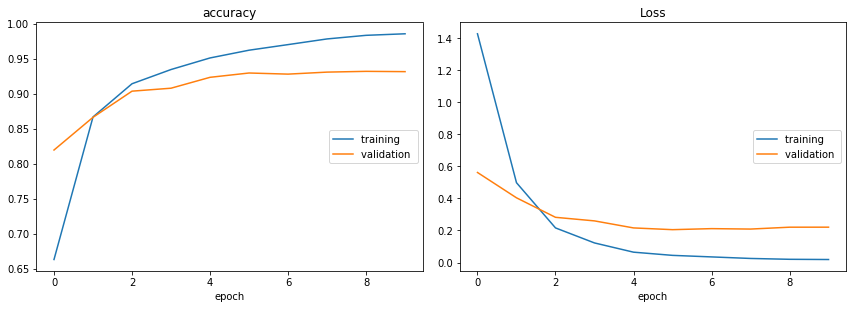

accuracy
	training         	 (min:    0.663, max:    0.985, cur:    0.985)
	validation       	 (min:    0.819, max:    0.932, cur:    0.931)
Loss
	training         	 (min:    0.019, max:    1.425, cur:    0.019)
	validation       	 (min:    0.205, max:    0.561, cur:    0.220)
527/527 [==============================] - 12s 23ms/step - loss: 0.0189 - accuracy: 0.9854 - val_loss: 0.2204 - val_accuracy: 0.9313


In [100]:
history = model11.fit(train_generator,validation_data = test_generator,
                        epochs=epochs, batch_size=1, 
                        steps_per_epoch = len(x3train), validation_steps = len(x3test), 
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=verbose)

In [101]:
# save model
MODEL_FILE = "Models/td3d-bilstm 19 class GD concat fbf reshaped md.json" # GD: gesture detector, fbf: frame-by-frame
WEIGHT_FILE ="Models/td3d-bilstm 19 class GD concat fbf reshaped md.h5" # save path

model_json = model11.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model11.save_weights(WEIGHT_FILE)

## Reshaped RD/RA, Detector + frame-by-frame

In [157]:
# Mask reshaped RD and RA
x1train = []
y1train = []
flag = 0
for i in range(len(mask_spect_tr)):
    for j in range(mask_spect_tr.shape[1]):
        if mask_spect_tr[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x1train.append(x_train12[i,startpt:stoppt])
                    y1train.append(np.squeeze(np.argmax(y_train3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1train = np.asarray(x1train)
y1train = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1train)])
x1test = []
y1test = []
flag = 0
for i in range(len(mask_spect_ts)):
    for j in range(mask_spect_ts.shape[1]):
        if mask_spect_ts[i,j] == 0:
            if flag == 0:
                continue
            else:
                stoppt = j
                if stoppt-startpt>2:
                    x1test.append(x_test12[i,startpt:stoppt])
                    y1test.append(np.squeeze(np.argmax(y_test3[i,startpt:stoppt],-1)))
                    flag = 0
        else:
            if flag == 0:
                startpt = j
                flag = 1
            else:
                continue
x1test = np.asarray(x1test)
y1test = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y1test)])
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)

(1154,)
(1154,)
(272,)
(272,)


In [158]:
def compute_class_w8(y):
    yw8 = np.concatenate([np.argmax(yx,-1) for yx in y],0)
#     yw8 = np.concatenate([np.squeeze(np.argmax(yx,-1)) for yx in y],0)
#     yint = np.argmax(y,-1)
    yint = [np.argmax(yx,-1) for yx in y]
#     yint = np.array([np.squeeze(np.argmax(yx,-1)) for yx in y])
    uniqs = np.unique(yw8)
    class_weights = class_weight.compute_class_weight('balanced',uniqs,yw8)
    temp_w8 = np.array([y.astype(np.float64) for y in yint])
    for j in range(len(y)):
        for i in range(0,len(uniqs)):
            temp_w8[j][yint[j]==i] = class_weights[i]
    return temp_w8, class_weights

In [159]:
model11 = tdcnn3d_bilstm()
# temp_w8, class_weights = compute_temporal_class_w8(y_train_win)
# train_generator = data_generator_temporal_w8(x_train12, y_train_win, temp_w8)
temp_w8, class_weights = compute_class_w8(y1train)
# train_generator = data_generator_temporal_w8(x1train, y1train, temp_w8)
train_generator = data_generator(x1train, y1train)
test_generator = data_generator(x1test, y1test)
# model11.summary()

In [160]:
class_weights

array([0.33221684, 0.18454829, 0.4770541 , 0.52202481, 2.4987163 ,
       2.30218805, 2.30867309, 2.34836375, 1.98445266, 2.14549463,
       2.30867309, 2.17973124, 2.03369466, 2.94812571, 2.27660819,
       2.23928674, 2.50635764, 2.32175339, 2.18554386])

In [161]:
temp_w8[222]

array([0.33221684, 0.33221684, 0.18454829, 0.18454829, 0.18454829,
       0.18454829, 0.18454829, 0.18454829, 0.18454829, 0.18454829,
       0.18454829, 0.18454829, 0.18454829, 0.18454829, 0.18454829,
       0.18454829, 0.18454829, 0.18454829, 0.18454829])

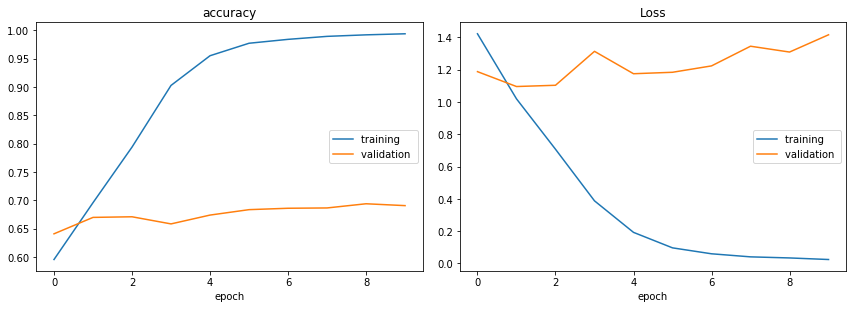

accuracy
	training         	 (min:    0.131, max:    0.994, cur:    0.994)
	validation       	 (min:    0.282, max:    0.932, cur:    0.691)
Loss
	training         	 (min:    0.019, max:    3.089, cur:    0.025)
	validation       	 (min:    0.205, max:    2.718, cur:    1.416)
1154/1154 [==============================] - 26s 22ms/step - loss: 0.0246 - accuracy: 0.9938 - val_loss: 1.4160 - val_accuracy: 0.6905


In [162]:
history = model11.fit(train_generator,validation_data = test_generator,
                        epochs=epochs, batch_size=1, 
                        steps_per_epoch = len(x1train), validation_steps = len(x1test), 
                        shuffle=False, callbacks = [PlotLossesKerasTF()], 
                        verbose=verbose)

In [163]:
# save model
MODEL_FILE = "Models/td3d-bilstm 19 class GD fbf reshaped ra.json" # GD: gesture detector, fbf: frame-by-frame
WEIGHT_FILE ="Models/td3d-bilstm 19 class GD fbf reshaped ra.h5" # save path

model_json = model11.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model11.save_weights(WEIGHT_FILE)